

---



---



---

#과제 1

In [1]:
# Basic tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DL tools
import torch 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# OS tool
import os

# Device setting & configuration
# cuda가 available하면 cuda(GPU)로 아니면 CPU 연결
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


In [2]:
# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Min-Max scaling
x_train = x_train/255.0
x_test = x_test/255.0

# Split train data into Train/Validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle=True)

# Check data shape
print(f"Train 데이터 크기: {x_train.shape, y_train.shape}")
print(f"Validation 데이터 크기: {x_val.shape, y_val.shape}")
print(f"Test 데이터 크기:{x_test.shape, y_test.shape}")

11490434/11490434 [==============================] - 2s 0us/step
Train 데이터 크기: ((48000, 28, 28), (48000,))
Validation 데이터 크기: ((12000, 28, 28), (12000,))
Test 데이터 크기:((10000, 28, 28), (10000,))


In [3]:
class Mydataset(torch.utils.data.Dataset):

    # 데이터 전처리 
    def __init__(self, dataX_np , dataY_np):
        self.data_X = dataX_np.astype(np.float32)
        self.data_Y = dataY_np.astype(np.float32) 

        print(f"My_dataset __init__ received : {self.data_X.shape}, {self.data_Y.shape} ")

    # 인덱스를 입력받아 인덱스에 알맞는 입출력 데이터를 Return
    def __getitem__(self, index):
        image = self.data_X[index]
        label = self.data_Y[index]
        # One hot encoding
        # 0~9 숫자로 되어있는 라벨을 one hot encoding 형식으로 변환합니다. 이는 이후 MLP의 출력이 10차원이기에 Loss를 계산하기 위해 진행하였습니다.  
        label = to_categorical(label, num_classes = 10)

        return image, label
    
    # 총 데이터 개수를 Return
    def __len__(self):
        return len(self.data_X)

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(Mydataset(x_train.reshape(-1,28*28), y_train), batch_size=batch_size, shuffle=False, drop_last = False)
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val.reshape(-1,28*28), y_val), batch_size = 1000000000, shuffle=False, drop_last = False)
test_loader = torch.utils.data.DataLoader(Mydataset(x_test.reshape(-1,28*28), y_test), batch_size = 100000000, shuffle=False, drop_last = False)

My_dataset __init__ received : (48000, 784), (48000,) 
My_dataset __init__ received : (12000, 784), (12000,) 
My_dataset __init__ received : (10000, 784), (10000,) 


In [5]:
class MLP_fit(nn.Module):
    def __init__(self):
        super(MLP_fit, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        # Weight Initialization
        torch.nn.init.xavier_normal_(self.fc1.weight.data, gain=1.0)
        torch.nn.init.xavier_normal_(self.fc2.weight.data, gain=1.0)
        torch.nn.init.xavier_normal_(self.fc3.weight.data, gain=1.0)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        # Pytorch에서는 Softmax가 CrossEntropy함수안에 내장되어있기에 없어도 됩니다. 
        # 이후 Loss를 CrossEntropy를 사용할 것이기에 제외하였습니다.
        # x = F.log_softmax(x, dim=1)

        return x

In [6]:
from statistics import mean 
import time

'''
 모델의 학습을 정의하는 함수입니다.
 model, Lossfunction, Optimizer, Scheduler 등을 입력받습니다.
 출력은 train, valdation, test의 loss 리스트로 하였습니다.
 train함수를 사용하면 입력받은 loss와 optimizer, lr scheduler, num_epoch에 따라 model을 학습시킵니다.
'''

def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):
    
    train_losses = []
    valid_losses = []
    test_losses = []

    print("----------------------------------------------------------------------------")

    start_time = time.time()
    for epoch in range(first_epoch, first_epoch + num_epochs):
        # train phase
        model.train()
        
        # batch_loss 
        batch_losses = []

        for images, labels in train_loader:
            
            # Move the training data to the GPU
            images = images.to(device)   
            labels = labels.to(device)

            # clear previous gradient computation
            optimizer_.zero_grad()

            # forward propagation
            outputs = model(images)

            # calculate the loss
            loss = criterion_.forward(outputs, labels)
            batch_losses.append(loss.item())

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer_.step()

        # Train loss를 저장합니다.
        train_losses.append(mean(batch_losses))

        # validation phase
        # Dropout, BatchNormalization과 같은 layer가 동작하지 않도록 합니다.
        model.eval()

        # We don't need gradients for test, so wrap in 
        # no_grad to save memory
        # 기울기 Gradient를 계산하지 않으며 backpropagation을 하지 않습니다. 
        with torch.no_grad():
            
            correct_test = 0

            for images, labels in valid_loader:

                # Move the training batch to the GPU
                images = images.to(device)
                labels = labels.to(device)

                # forward propagation
                outputs = model(images)

                # calculate the loss
                loss = criterion_(outputs, labels)
                valid_losses.append(loss.item())

            for images, labels in test_loader:
                # Move the training batch to the GPU
                images = images.to(device)
                labels = labels.to(device)

                # forward propagation
                outputs = model(images)

                # calculate the loss
                loss = criterion_(outputs, labels)
                test_losses.append(loss.item())

                # Check Accuracy
                # preds 는 output 중에서 가장 높은 값의 index를 가집니다. 
                _, preds = torch.max(outputs, 1)

                # label이 현재 one hot encoding 형태로 되어있기에 preds를 index로 받아 1인지 확인합니다. 
                # ex) 숫자 2 : label = [0,0,1,0,0,...,0] , label[i][preds] == 1 -> 정답
                for i in range(len(preds)):
                  if labels[i][preds[i]] == 1:
                    correct_test +=1
        
        # 원하는 Epoch마다 결과 출력 
        if (epoch) % 1== 0 :
            curr_time = round(time.time()-start_time)
            train_rec = round(train_losses[-1],5)
            valid_rec = round(valid_losses[-1],5)
            test_rec = round(test_losses[-1],5)
            test_acc = round(100*(correct_test)/len(labels),3)
            print('Epoch', epoch, ' / ',num_epochs)
            print(f"\t [Train loss : {train_rec}]  [Validation loss : {valid_rec}] [Test loss : {test_rec}], [Test Accuracy : {test_acc}%],[curr LR = {scheduler_.get_last_lr()}],[elapsed_time = {curr_time}sec] ")

        # Learning rate Scheduling
        # Scheduler에 따라 learning rate를 조절합니다. 
        scheduler_.step()
        
      
    print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")
    print("--------------------------------------------------------------------")
    
    # Loss 값 반환
    return train_losses, valid_losses, test_losses

In [12]:
# Moodel Setting 
model = MLP_fit()
model.to(device)

# Optimizer
# Optimzer와 Learning rate를 설정해줍니다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Loss Function
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
# epoch가 10번 돌때마다 learning rate를 gamma만큼 곱해 사용합니다. ex) 0.01 -> 0.005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [13]:
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=30)

----------------------------------------------------------------------------
Epoch 1  /  30
	 [Train loss : 0.40477]  [Validation loss : 0.20395] [Test loss : 0.19683], [Test Accuracy : 94.55%],[curr LR = [0.0001]],[elapsed_time = 20sec] 
Epoch 2  /  30
	 [Train loss : 0.17018]  [Validation loss : 0.14715] [Test loss : 0.14256], [Test Accuracy : 95.84%],[curr LR = [0.0001]],[elapsed_time = 36sec] 
Epoch 3  /  30
	 [Train loss : 0.12208]  [Validation loss : 0.11848] [Test loss : 0.11549], [Test Accuracy : 96.68%],[curr LR = [0.0001]],[elapsed_time = 52sec] 
Epoch 4  /  30
	 [Train loss : 0.09305]  [Validation loss : 0.10191] [Test loss : 0.09962], [Test Accuracy : 97.1%],[curr LR = [0.0001]],[elapsed_time = 69sec] 
Epoch 5  /  30
	 [Train loss : 0.0728]  [Validation loss : 0.09181] [Test loss : 0.089], [Test Accuracy : 97.27%],[curr LR = [0.0001]],[elapsed_time = 85sec] 
Epoch 6  /  30
	 [Train loss : 0.05763]  [Validation loss : 0.08557] [Test loss : 0.08205], [Test Accuracy : 97.42%],

In [14]:
def plot_result(train_loss, val_loss, test_loss):
  plt.figure(figsize=(20,8))
  plt.plot(train_loss, label='Train Loss', linewidth='3')
  plt.plot(val_loss, label='Validation Loss', linewidth='3')
  plt.plot(test_loss, label='Test Loss', linewidth='3')
  plt.grid()
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)  
  plt.legend()
  plt.rc('legend', fontsize=15)  
  plt.xlabel('Number of Eopch')
  plt.ylabel('Cross Entropy Loss')
  plt.rc('axes', labelsize=17)  

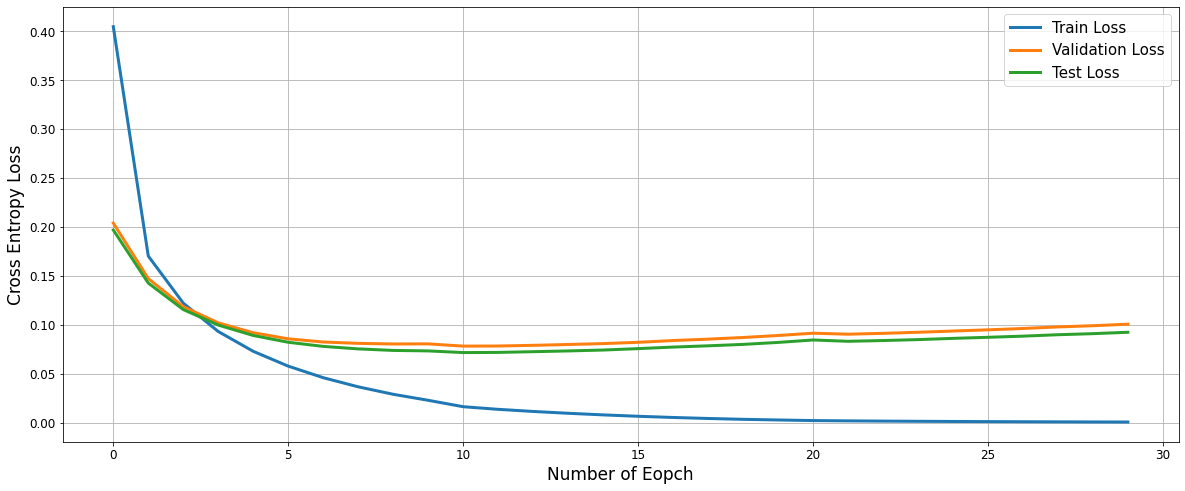

In [15]:
plot_result(train_losses, valid_losses, test_losses)



---



---



---

#과제 2

In [11]:
'''
# function_2d
# Input : x , y
# output : z = f(x,y)
'''
def function_2d(x,y):
  term_sqrt = np.sqrt(x*x+y*y)
  term1 = np.sin(20*term_sqrt)/(20*term_sqrt)
  term2 = (1/5)*np.cos(10*term_sqrt)
  term3 = y/2 - 0.3
  label = term1 + term2 + term3
  return label

'''
# generate_data
# input : dim (int)
# output : (10000, 3) dataset, type : np.array
- first column : x
- second column : y
- third column : f(x,y) (True label)
'''
def generate_data(dim):
  x = np.linspace(-1, 1, dim)
  y = np.linspace(-1, 1, dim)
  xx, yy = np.meshgrid(x,y)
  zz = function_2d(xx,yy)
  data_1 = xx.reshape(-1,1)
  data_2 = yy.reshape(-1,1)
  label = zz.reshape(-1,1)
  dataset = np.hstack((data_1, data_2))
  dataset = np.hstack((dataset, label))
  return dataset

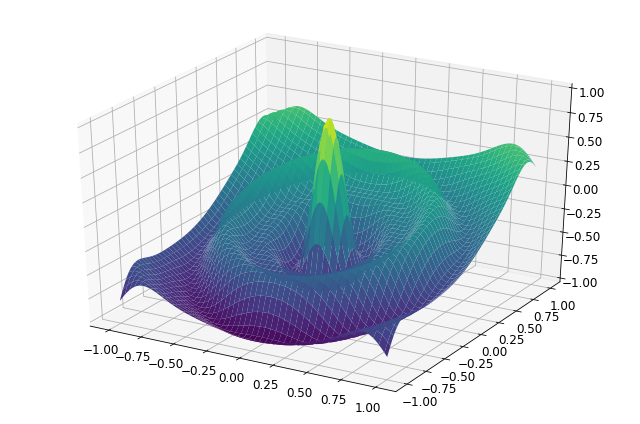

In [17]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
xx, yy = np.meshgrid(x,y)
zz = function_2d(xx,yy)
surf = ax.plot_surface(xx, yy, zz, cmap='viridis')
surf.set_clim(-1.0, 1.0)
ax.view_init(30,-60)
ax.set_zticks([-1,1])
ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25))
plt.tight_layout()
plt.show()

In [18]:
class Mydataset(torch.utils.data.Dataset):
  def __init__(self, dataX_np , dataY_np):
    self.data_X = dataX_np.astype(np.float32)
    self.data_Y = dataY_np.astype(np.float32)
    print(f"My_dataset __init__ received : {self.data_X.shape}, {self.data_Y.shape} ")
  def __getitem__(self, index):
    batch = self.data_X[index]
    target = self.data_Y[index]
    return batch, target
  def __len__(self):
    return len(self.data_X)

In [19]:
dataset = generate_data(100)

In [20]:
x = dataset[:, :2]
y = dataset[:,2:]
# train-temp 분리 (7:3)
x_train, x_temp, y_train, y_temp = train_test_split(x,y,test_size=0.3, shuffle=True)
# temp 에서 validation-test 분리 3 -> 1.5:1.5
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,shuffle=True)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_test.shape)

(7000, 2)
(1500, 2)
(1500, 2)
(1500, 1)


In [32]:
class SimpleMLP(nn.Module):
  def __init__(self, input_ = 2, output_ = 1):
    super(SimpleMLP, self).__init__()
    self.fc1 = nn.Linear(input_, 8)
    self.fc2 = nn.Linear(8, 16)
    self.fc3 = nn.Linear(16, 32)
    self.fc4 = nn.Linear(32, 64)
    self.fc5 = nn.Linear(64,output_)

  def forward(self, x):
    x = self.fc1(x)
    x = F.tanh(x)
    x = self.fc2(x)
    x = F.tanh(x)
    x = self.fc3(x)
    x = F.tanh(x)
    x = self.fc4(x)
    x = F.tanh(x)
    x = self.fc5(x)
    return x

In [23]:
batch_size = 1000000
train_loader = torch.utils.data.DataLoader(Mydataset(x_train, y_train), batch_size=batch_size, shuffle=False, drop_last = False)
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val, y_val), batch_size=batch_size, shuffle=False, drop_last = False)
test_loader = torch.utils.data.DataLoader(Mydataset(x_test, y_test), batch_size=batch_size, shuffle=False, drop_last = False)

My_dataset __init__ received : (7000, 2), (7000, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 


In [25]:
from statistics import mean
import time
def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):
  train_losses = []
  valid_losses = []
  test_losses = []
  print("----------------------------------------------------------------------------")
  start_time = time.time()

  for epoch in range(first_epoch, first_epoch + num_epochs):
    # train phase
    model.train()
    # batch_loss
    batch_losses = []

    for samples, labels in train_loader:
      # Move the training data to the GPU
      samples = samples.to(device)
      labels = labels.to(device)
      # clear previous gradient computation
      optimizer_.zero_grad()
      # forward propagation
      outputs = model(samples)
      # calculate the loss
      loss = criterion_.forward(outputs, labels)
      batch_losses.append(loss.item())
      # backpropagate to compute gradients
      loss.backward()
      # update model weights
      optimizer_.step()
      # Train loss 를 저장합니다.

    train_losses.append(mean(batch_losses))
    # validation phase
    # Dropout, BatchNormalization 과 같은 layer 가 동작하지 않도록 합니다.
    model.eval()
    # We don't need gradients for test, so wrap in
    # no_grad to save memory

    # 기울기 Gradient 를 계산하지 않으며 backpropagation 을 하지 않습니다.
    with torch.no_grad():
      for samples, labels in valid_loader:
        # Move the training batch to the GPU
        samples = samples.to(device)
        labels = labels.to(device)
        # forward propagation
        outputs = model(samples)
        # calculate the loss
        loss = criterion_(outputs, labels)
        valid_losses.append(loss.item())
      for samples, labels in test_loader:
        # Move the training batch to the GPU
        samples = samples.to(device)
        labels = labels.to(device)
        # forward propagation
        outputs = model(samples)
        # calculate the loss
        loss = criterion_(outputs, labels)
        test_losses.append(loss.item())

  # 원하는 Epoch 마다 결과 출력
    if (epoch) % 1000== 0 :
      curr_time = round(time.time()-start_time)
      train_rec = round(train_losses[-1],5)
      valid_rec = round(valid_losses[-1],5)
      test_rec = round(test_losses[-1],5)
      print('Epoch', epoch, ' / ',num_epochs)
      print(f"\t [Train loss : {train_rec}] [Validation loss : {valid_rec}] [Test loss : {test_rec}] [curr LR = {scheduler_.get_last_lr()}],[elapsed_time = {curr_time}sec] ")
      # Learning rate Scheduling
      # Scheduler 에 따라 learning rate 를 조절합니다.

    scheduler_.step()

  print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")
  print("--------------------------------------------------------------------")
  # Loss 값 반환
  return train_losses, valid_losses, test_losses

In [33]:
model = SimpleMLP()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5) 
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=10000)

----------------------------------------------------------------------------


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 1000  /  10000
	 [Train loss : 0.02582] [Validation loss : 0.02729] [Test loss : 0.02482] [curr LR = [0.1]],[elapsed_time = 98sec] 
Epoch 2000  /  10000
	 [Train loss : 0.04547] [Validation loss : 0.05702] [Test loss : 0.05462] [curr LR = [0.1]],[elapsed_time = 190sec] 
Epoch 3000  /  10000
	 [Train loss : 0.00607] [Validation loss : 0.00799] [Test loss : 0.00585] [curr LR = [0.05]],[elapsed_time = 284sec] 
Epoch 4000  /  10000
	 [Train loss : 0.00697] [Validation loss : 0.00574] [Test loss : 0.0056] [curr LR = [0.05]],[elapsed_time = 382sec] 
Epoch 5000  /  10000
	 [Train loss : 0.0011] [Validation loss : 0.00157] [Test loss : 0.00144] [curr LR = [0.025]],[elapsed_time = 478sec] 
Epoch 6000  /  10000
	 [Train loss : 0.00098] [Validation loss : 0.00137] [Test loss : 0.0012] [curr LR = [0.025]],[elapsed_time = 572sec] 
Epoch 7000  /  10000
	 [Train loss : 0.00038] [Validation loss : 0.00057] [Test loss : 0.00044] [curr LR = [0.0125]],[elapsed_time = 667sec] 
Epoch 8000  /  10000
	

In [34]:
def plot_result(train_loss, val_loss, test_loss): 
  plt.figure(figsize=(20,8))
  plt.plot(train_loss, label='Train Loss', linewidth='3') 
  plt.plot(val_loss, label='Validation Loss', linewidth='3') 
  plt.plot(test_loss, label='Test Loss', linewidth='3') 
  plt.grid()
  plt.rc('xtick', labelsize=12) 
  plt.rc('ytick', labelsize=12) 
  plt.legend()
  plt.rc('legend', fontsize=15) 
  plt.xlabel('Number of Eopch') 
  plt.ylabel('MSE Loss') 
  plt.rc('axes', labelsize=17)

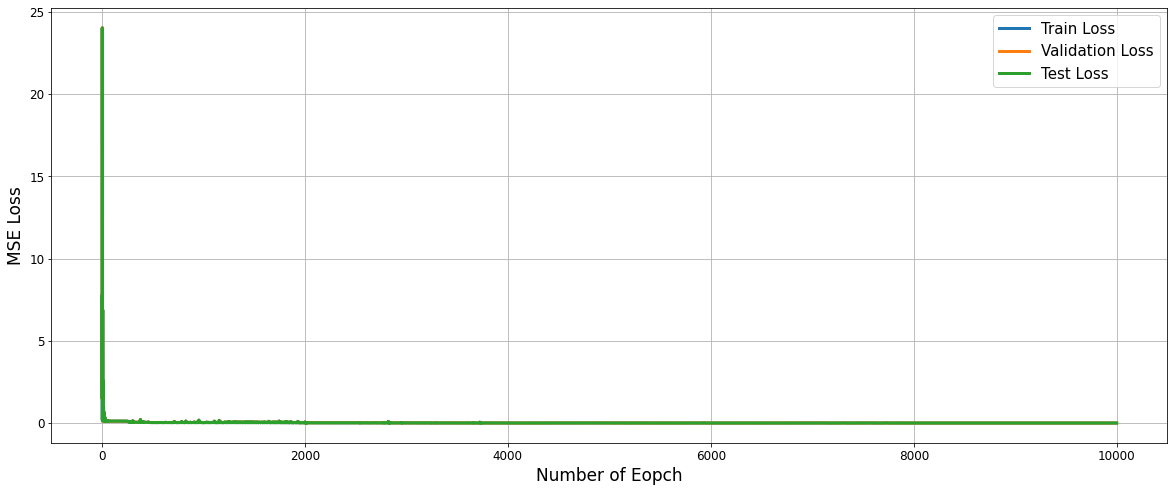

In [35]:
plot_result(train_losses, valid_losses, test_losses)

In [36]:
def visual_graph(model):
  x = np.linspace(-1, 1, 100)
  y = np.linspace(-1, 1, 100)
  xx,yy = np.meshgrid(x,y)
  xx = xx.reshape(-1,1)
  yy = yy.reshape(-1,1)
  inp_np = np.hstack((xx,yy))
  inp_tensor = torch.Tensor(inp_np)
  inp_tensor = inp_tensor.to(device)
  zz = model(inp_tensor)
  pred_output = zz.detach().cpu().numpy()
  fig = plt.figure(figsize=(9, 6))
  ax = fig.add_subplot(111, projection='3d')
  xx = xx.reshape(100,100)
  yy = yy.reshape(100,100)
  pred_output = pred_output.reshape(100,100)
  surf = ax.plot_surface(xx, yy, pred_output, cmap='viridis') 
  surf.set_clim(-1.0, 1.0)
  ax.view_init(30,-60)
  ax.set_zticks([-1,1]) 
  ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25)) 
  plt.tight_layout()
  plt.show()

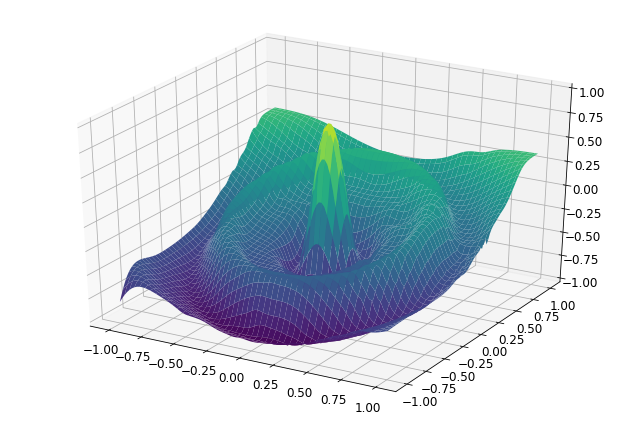

In [37]:
visual_graph(model)